In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing, linear_model, metrics

from mlxtend.plotting import plot_decision_regions 
import tensorflow as tf

%matplotlib inline

/Users/abulbasar/anaconda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
import requests
url = "https://raw.githubusercontent.com/abulbasar/machine-learning/master/Utils.py"
exec(requests.get(url).text)

In [3]:
df_train = pd.read_csv("/data/MNIST/mnist_train.csv")
df_test = pd.read_csv("/data/MNIST/mnist_test.csv")

In [4]:
X_train = df_train.iloc[:, 1:].values.astype(np.float32)
X_test = df_test.iloc[:, 1:].values.astype(np.float32)

scaler = preprocessing.StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)
y_train = df_train.values[:, 0]
y_test = df_test.values[:, 0]

X Tensor("X:0", shape=(?, 784), dtype=float32)
y Tensor("y:0", shape=(?,), dtype=int32)
X_image Tensor("Reshape:0", shape=(?, 28, 28, 1), dtype=float32)
conv_layer1 Tensor("MaxPool:0", shape=(?, 14, 14, 32), dtype=float32)
conv_layer2 Tensor("MaxPool_1:0", shape=(?, 7, 7, 64), dtype=float32)
flat Tensor("Relu_2:0", shape=(?, 3136), dtype=float32)
y_pred Tensor("ArgMax:0", shape=(?,), dtype=int32)
0 training cost:  7.94528 training accuracy:  0.132812
50 training cost:  0.514822 training accuracy:  0.8125
100 training cost:  0.689558 training accuracy:  0.921875
150 training cost:  0.29047 training accuracy:  0.914062
200 training cost:  0.0793214 training accuracy:  0.960938
250 training cost:  0.144428 training accuracy:  0.9375
300 training cost:  0.0960415 training accuracy:  0.96875
350 training cost:  0.24257 training accuracy:  0.929688
400 training cost:  0.0694593 training accuracy:  0.96875
450 training cost:  0.0799595 training accuracy:  0.960938
500 training cost:  0.068370

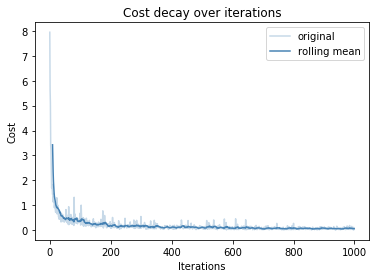

In [5]:
%%time

tf.reset_default_graph()
tf.set_random_seed(1)
n_x = X_train_std.shape[1]
n_y = 10
n_h = 200
max_iters = 1000
learning_rate = 0.001

X = tf.placeholder(dtype=tf.float32, shape=[None, n_x], name="X")
y = tf.placeholder(dtype=tf.int32, shape=[None], name="y")
keep_prob = tf.placeholder_with_default(input=1.0, shape=[])
print("X", X)
print("y", y)

y_oh = tf.one_hot(indices=y, depth=n_y)

X_image = tf.reshape(X, shape=[-1, 28, 28, 1])

print("X_image", X_image)

def conv_layer(input, shape):
    """
    The initial 5×5×1 represents the size of the small “window” in the image to be convolved, 
    in our case a 5×5 region. The final 32 is the number of feature maps. In other words, 
    we have multiple sets of weights for the convolutional layer—in this case, 32 of them. 

    The value [1, 1, 1, 1] for strides means that the filter is applied to the input in one-pixel 
    intervals in each dimension, corresponding to a “full” convolution. 
    Setting padding to 'SAME' means that the borders of x are padded such that the size 
    of the result of the operation is the same as the size of x.
    
    Pooling means reducing the size of the data with some local aggregation function. One reason 
    for applying pooling is that we would like our computed features not to care about small changes 
    in position in an image. 
    
    Max pooling outputs the maximum of the input in each region of a predefined size 
    (here 2×2). The ksize argument controls the size of the pooling (2×2), 
    and the strides argument controls by how much we “slide” the pooling grids across x,
    just as in the case of the convolution layer. Setting this to a 2×2 grid means 
    that the output of the pooling will be exactly one-half of the height and width 
    of the original, and in total one-quarter of the size.
    """    
    
    W = tf.Variable(tf.truncated_normal(shape=shape, stddev=0.1))
    b = tf.Variable(tf.constant(0.1, shape=[shape[3]]))
    conv = tf.nn.conv2d(input, W, strides=[1, 1, 1, 1], padding="SAME")
    A = tf.nn.relu(conv + b)
    pool_layer = tf.nn.max_pool(A, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    return pool_layer


def full_layer(input, size, activation = None, keep_prob = None):
    input_size = int(input.get_shape()[1])
    W = tf.Variable(tf.truncated_normal(stddev=0.1, shape=[input_size, size]))
    b = tf.Variable(tf.constant(0.1, shape=[size]))
    Z = tf.matmul(input, W) + b
    if callable(activation):
        Z = activation(Z)
    
    if not keep_prob is None:
        Z = tf.nn.dropout(x=Z, keep_prob = keep_prob)
    return Z

conv_layer1 = conv_layer(X_image, [5, 5, 1, 32])
print("conv_layer1", conv_layer1)

conv_layer2 = conv_layer(conv_layer1, [5, 5, 32, 64])
print("conv_layer2", conv_layer2)

conv2_shape = conv_layer2.get_shape() 
flat_size = conv2_shape[1] * conv2_shape[2] * conv2_shape[3]
flat = tf.nn.relu(tf.reshape(conv_layer2, [-1, flat_size]))
print("flat", flat)

full_layer_1 = full_layer(flat, n_h, activation = tf.nn.relu, keep_prob = keep_prob)
full_layer_2 = full_layer(full_layer_1, n_y)
Z_out = full_layer_2

y_pred = tf.argmax(tf.nn.softmax(Z_out), axis=1, output_type=tf.int32) 
print("y_pred", y_pred)

accuracy = tf.reduce_mean(tf.cast(tf.equal(y_pred, y), tf.float32))

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_oh, logits=Z_out))

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)


with tf.Session() as sess:
    scores = {}
    sess.run(tf.global_variables_initializer())
        
    batchable = Batchable(X_train_std, y_train, batch_size=128)

    for i in range(max_iters):
        X_batch, y_batch = batchable.next()
        accuracy_, cost_, _ = sess.run([accuracy, cost, optimizer]
                        , feed_dict={X: X_batch, y: y_batch, keep_prob: 0.8})
        scores[i] = cost_
        if i % (max_iters // 20) == 0 or i == (max_iters - 1): 
            print(i, "training cost: ", cost_, "training accuracy: ", accuracy_)
            
    accuracy_ = sess.run(accuracy, feed_dict={X: X_test_std, y: y_test, keep_prob: 1.0})
    print("Test accuracy: ", accuracy_)
    plot_scores(scores)

    y_test_pred = sess.run(y_pred, feed_dict={X: X_test_std})


Text(0.5,1,'Wrong predictions (%) by class')

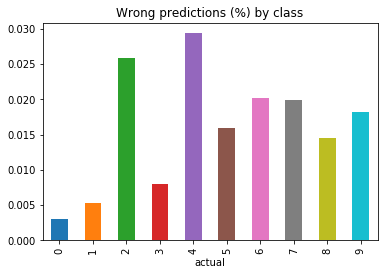

In [6]:
result = pd.DataFrame({"predict": y_test_pred, "actual": y_test})
result["match"] = np.where(result.actual == result.predict, 1, 0)
result_agg = result.groupby(["actual", "match"]).count().unstack()
result_agg["ratio"] = result_agg.iloc[:, 0] / result_agg.iloc[:, 1]
result_agg.ratio.plot.bar()
plt.title("Wrong predictions (%) by class")

In [7]:
matched = result.match
wrong_idx = matched[matched == 0].index
print("Total wrong predictions", len(wrong_idx))

Total wrong predictions 156


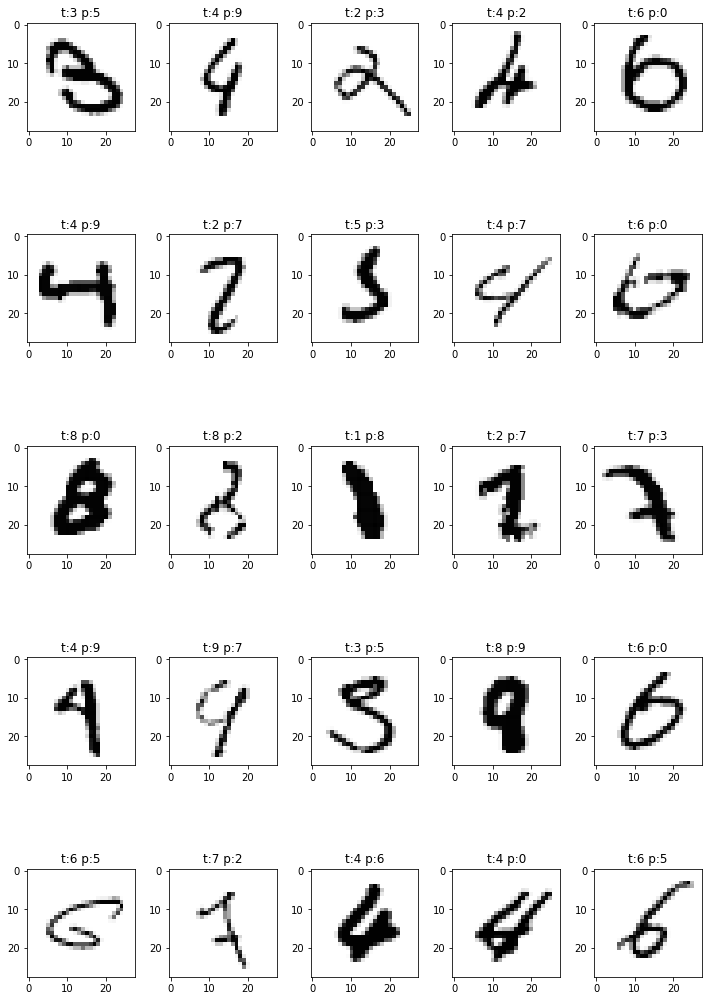

In [8]:
fig, _ = plt.subplots(5, 5, figsize = (10, 15))
for i, ax in enumerate(fig.axes):
    index = wrong_idx[i]
    ax.imshow(X_test[index, :].reshape(28, 28), cmap = "Greys")
    ax.set_title("t:" +  str(y_test[index])
                            + " p:" +  str(y_test_pred[index]))
    
plt.tight_layout()